In [1]:
!pip install -q geopandas
!pip install -q fiona
!pip install -q folium
!pip install -q geopy # 지리적 위치의 위도와 경도를 기반으로 거리 계산을 쉽게 할 수 있게 해주는 라이브러리

## 라이브러리 임포트

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
from geopy.distance import geodesic
from tqdm.notebook import tqdm
import matplotlib.font_manager as fm
import seaborn as sns

fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')

## 지하철역에 대한 구별 집계를 위한 기본 지도

In [3]:
subway = pd.read_csv('../subway_feature.csv')
subway.head(10)

,역사_ID,역사명,호선,위도,경도
0,9996,미사,5호선,37.560927,127.193877
1,9995,강일,5호선,37.557490,127.175930
2,4929,김포공항,김포골드라인,37.562360,126.801868
3,4928,고촌,김포골드라인,37.601243,126.770345
4,4927,풍무,김포골드라인,37.612488,126.732387
5,4926,사우(김포시청),김포골드라인,37.620249,126.719731
6,4925,걸포북변,김포골드라인,37.631650,126.705975
7,4924,운양,김포골드라인,37.653867,126.683930
8,4923,장기,김포골드라인,37.643986,126.669017
9,4922,마산,김포골드라인,37.640732,126.644344


In [4]:
# 서울시의 중심 위도와 경도
x = 37.5665
y = 126.9780

# 서울시 중심에 지도를 생성하고, 시작 확대 레벨을 11로 설정
m = folium.Map(location=(x, y), zoom_start=11)

# 데이터프레임의 각 행을 반복하면서 마커 추가
for index, row in subway.iterrows():
    folium.Marker([row['위도'], row['경도']], popup=row['역사명']).add_to(m)

# 지도 출력
m

- `subway_feature.csv`에 있는 지하철역을 시각화하면 서울에서 벗어난 역도 존재하는 것을 확인할 수 있다.
- 서울시를 벗어나는 역을 찾으려면 먼저 서울시의 경계를 위도와 경도로 정의해야 한다. 
- 서울시의 대략적인 최소와 최대 위도, 최소와 최대 경도를 사용하여 서울시 경계를 정의할 수 있다.

    - 최소 위도 : 약 37.425
    - 최대 위도 : 약 37.715
    - 최소 경도 : 약 126.765
    - 최대 경도 : 약 127.183

In [5]:
# 서울시의 경계 위도와 경도
seoul_lat_min, seoul_lat_max = 37.429, 37.701
seoul_lon_min, seoul_lon_max = 126.764, 127.183

# 서울시 내에 있는 역 필터링
seoul_stations = subway[(subway['위도'] >= seoul_lat_min) & (subway['위도'] <= seoul_lat_max) &
                    (subway['경도'] >= seoul_lon_min) & (subway['경도'] <= seoul_lon_max)]

seoul_stations.head()

,역사_ID,역사명,호선,위도,경도
1,9995,강일,5호선,37.557490,127.175930
2,4929,김포공항,김포골드라인,37.562360,126.801868
3,4928,고촌,김포골드라인,37.601243,126.770345
20,4807,신천,서해선,37.439066,126.786788
21,4806,시흥대야,서해선,37.450145,126.793041


## 아파트 및 지하철역 시각화

In [6]:
gdf_seoul = gpd.read_file('../geo/LARD_ADM_SECT_SGG_11_202403.shp', encoding='cp949')
gdf_seoul = gdf_seoul.to_crs(epsg=4326)
gdf_seoul.head()

,ADM_SECT_C,SGG_NM,SGG_OID,COL_ADM_SE,geometry
0,11110,종로구,11,11110,"POLYGON ((126.97448 37.63425, 126.97526 37.634..."
1,11140,중구,34,11140,"POLYGON ((126.99072 37.57035, 126.99095 37.570..."
2,11170,용산구,1,11170,"POLYGON ((126.94539 37.53600, 126.94541 37.536..."
3,11200,성동구,1,11200,"POLYGON ((127.02758 37.56726, 127.02729 37.567..."
4,11215,광진구,49,11215,"POLYGON ((127.07772 37.52474, 127.07510 37.525..."


In [7]:
data = pd.read_csv('../train_lon_apt.csv', index_col=0)
data.head()

/tmp/ipykernel_722630/2836755354.py:1: DtypeWarning: Columns (14,15,16,17,18,20,21,22,23,26,27,28,36,37,38,39,40,41,42,45,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../train_lon_apt.csv', index_col=0)


,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,건축년도,...,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,is_test,지번주소
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,개포6차우성,124000.0,0,서울특별시 강남구 개포동 658-1
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,...,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,개포6차우성,123500.0,0,서울특별시 강남구 개포동 658-1
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,201712,28,5,1987,...,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,개포6차우성,91500.0,0,서울특별시 강남구 개포동 658-1
3,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,3,4,1987,...,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,개포6차우성,130000.0,0,서울특별시 강남구 개포동 658-1
4,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,8,2,1987,...,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,개포6차우성,117000.0,0,서울특별시 강남구 개포동 658-1


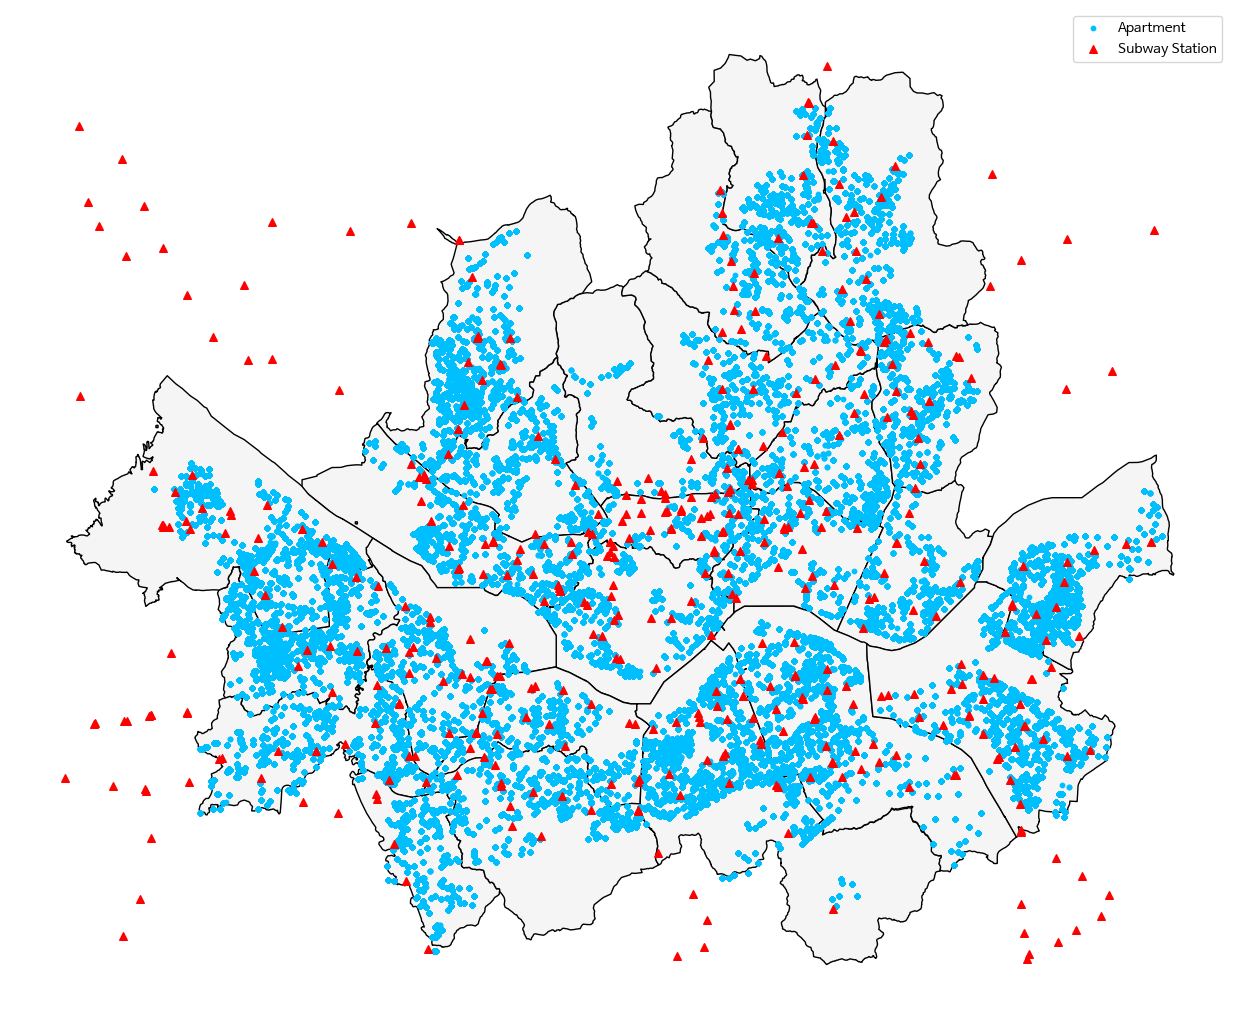

In [8]:
fig = plt.figure(figsize=(18, 13))
ax = fig.subplots(1, 1)
 
gdf_seoul.plot(color='whitesmoke', edgecolor='black', linewidth=1, ax=ax)

# 아파트 위치
apartments = plt.scatter(data['좌표X'],
                         data['좌표Y'],
                         color="deepskyblue",
                         label='Apartment',
                         s=10)

# 지하철역 위치
stations = plt.scatter(seoul_stations['경도'],
                       seoul_stations['위도'],
                       color="red",
                       marker='^',
                       label='Subway Station',
                       s=30)

# 레전드 추가
plt.legend(handles=[apartments, stations])

ax.set_axis_off()
plt.show()

## 역세권 시각화

In [9]:
print("학습 데이터의 크기: ", len(data))
print("학습 데이터에 있는 아파트명의 수: ", len(data['아파트명'].unique()))

학습 데이터의 크기:  1128094
학습 데이터에 있는 아파트명의 수:  6583


- 학습 데이터의 크기는 약 110만 개에 비해 학습 데이터에 있는 아파트명의 수는 약 6500개로 대부분 중복되어있음을 알 수 있다.
- 각 아파트의 위도와 경도를 기준으로 500m 이내 반경에 존재하는 지하철 역의 수를 구하기 위해서는 6500개의 데이터로 충분하다고 할 수 있다.
- 우선 학습 데이터 중에서 아파트명이 중복되는 행 중 첫번째 값만 남긴다.
- 이후 지하철 역의 수를 세기 위한 함수를 정의하고 '지하철역 수'라는 칼럼을 만들어 해당 함수를 적용한다.

In [10]:
# 아파트명을 기준으로 중복 행 제거 (첫 번째 행만 남김)
apts = data.drop_duplicates(subset=['아파트명'], keep='first')

apts.head()

,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,건축년도,...,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,is_test,지번주소
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,임의,2022-11-17 13:00:29.0,Y,N,127.057210,37.476763,개포6차우성,124000.0,0,서울특별시 강남구 개포동 658-1
12,서울특별시 강남구 개포동,652,652.0,0.0,개포우성3차,133.46,201710,13,1,1984,...,의무,1984-12-22 00:00:00.0,Y,N,127.055990,37.483894,개포우성3차,152000.0,0,서울특별시 강남구 개포동 652
25,서울특별시 강남구 개포동,12-2,12.0,2.0,개포자이,153.80,201710,13,19,2004,...,의무,2013-06-23 14:26:42.0,Y,N,127.076624,37.496296,개포자이,146000.0,0,서울특별시 강남구 개포동 12-2
38,서울특별시 강남구 개포동,141,141.0,0.0,개포주공1단지,41.98,201710,10,2,1982,...,기타,2013-06-23 14:21:02.0,Y,N,127.058521,37.480002,개포주공1단지,122000.0,0,서울특별시 강남구 개포동 141
204,서울특별시 강남구 개포동,187,187.0,0.0,개포주공5단지,74.25,201710,16,8,1983,...,의무,2015-03-02 11:08:24.0,Y,N,127.068028,37.487802,개포주공5단지,129000.0,0,서울특별시 강남구 개포동 187


In [11]:
from tqdm import tqdm
import pandas as pd
from math import radians, cos, sin, sqrt, atan2

# 하버사인 공식을 사용하여 두 지점 간의 거리 계산
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # 지구의 반지름(km)
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance * 1000  # m 단위로 변환

# 진행 상태를 표시하면서 주어진 반경 내 지하철역 수를 계산하는 함수
def count_stations(row, seoul_stations):
    apartment_location = (row['좌표Y'], row['좌표X'])  # 주의: (위도, 경도) 순서
    count = 0
    for _, station in seoul_stations.iterrows():
        station_location = (station['위도'], station['경도'])
        distance = haversine(*apartment_location, *station_location)
        if distance <= 500:  # 500m 이내
            count += 1
    return count

# pandas apply에 대한 tqdm 지원 활성화
tqdm.pandas()

# 예제 데이터프레임 생성 (apts, seoul_stations)은 예시 데이터
apts['지하철역 수'] = apts.progress_apply(lambda row: count_stations(row, seoul_stations), axis=1)

# 결과 확인 (이 부분은 예시 데이터가 없어 실행할 수 없음)
num_subway = apts[['아파트명', '지하철역 수']].reset_index(drop=True)
num_subway.to_csv('num_subway.csv')
num_subway



100%|██████████| 6583/6583 [01:35<00:00, 68.87it/s]
/tmp/ipykernel_722630/2005700551.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apts['지하철역 수'] = apts.progress_apply(lambda row: count_stations(row, seoul_stations), axis=1)


,아파트명,지하철역 수
0,개포6차우성,0
1,개포우성3차,1
2,개포자이,1
3,개포주공1단지,0
4,개포주공5단지,1
...,...,...
6578,수유시그니티,0
6579,더헤리츠,0
6580,신수동르끌레브,1
6581,히페리온리버팰리스,0


In [12]:
data_with_subway = pd.merge(data, num_subway, on="아파트명", how="inner")
data_with_subway

,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,건축년도,...,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,is_test,지번주소,지하철역 수
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.9700,201712,8,3,1987,...,2022-11-17 13:00:29.0,Y,N,127.057210,37.476763,개포6차우성,124000.0,0,서울특별시 강남구 개포동 658-1,0
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.9700,201712,22,4,1987,...,2022-11-17 13:00:29.0,Y,N,127.057210,37.476763,개포6차우성,123500.0,0,서울특별시 강남구 개포동 658-1,0
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.9800,201712,28,5,1987,...,2022-11-17 13:00:29.0,Y,N,127.057210,37.476763,개포6차우성,91500.0,0,서울특별시 강남구 개포동 658-1,0
3,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.9700,201801,3,4,1987,...,2022-11-17 13:00:29.0,Y,N,127.057210,37.476763,개포6차우성,130000.0,0,서울특별시 강남구 개포동 658-1,0
4,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.9700,201801,8,2,1987,...,2022-11-17 13:00:29.0,Y,N,127.057210,37.476763,개포6차우성,117000.0,0,서울특별시 강남구 개포동 658-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,서울특별시 강북구 수유동,87-5,87.0,5.0,수유시그니티,48.5900,202309,8,12,2023,...,NaN,NaN,NaN,127.023121,37.632291,수유시그니티,NaN,1,서울특별시 강북구 수유동 87-5,0
1128090,서울특별시 구로구 고척동,97,97.0,0.0,더헤리츠,56.0000,202307,24,17,2023,...,NaN,NaN,NaN,126.856629,37.499228,더헤리츠,NaN,1,서울특별시 구로구 고척동 97,0
1128091,서울특별시 마포구 신수동,400-1,400.0,1.0,신수동르끌레브,49.5400,202308,4,1,2023,...,NaN,NaN,NaN,126.935943,37.544878,신수동르끌레브,NaN,1,서울특별시 마포구 신수동 400-1,1
1128092,서울특별시 성동구 송정동,67-5,67.0,5.0,히페리온리버팰리스,83.4530,202309,4,2,2022,...,NaN,NaN,NaN,127.063437,37.548714,히페리온리버팰리스,NaN,1,서울특별시 성동구 송정동 67-5,0


In [13]:
# 힐스테이트 서초 젠트리스의 본번과 부번이 모두 결측치 값이다.
# 인터넷 검색 결과 힐스테이트 서초 젠트리스의 지번 주소는 신원동 557이기 때문에 본번과 부번을 0으로 채워도 될 거 같다.
data_with_subway[data_with_subway['부번'].isnull()]

,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,건축년도,...,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,is_test,지번주소,지하철역 수
669647,서울특별시 서초구 신원동,557,NaN,NaN,힐스테이트 서초 젠트리스,114.90,201801,6,6,2014,...,2018-02-27 14:49:46.0,Y,N,127.058537,37.456174,힐스테이트 서초 젠트리스,147000.0,0,서울특별시 서초구 신원동 557,0
669648,서울특별시 서초구 신원동,557,NaN,NaN,힐스테이트 서초 젠트리스,114.90,201801,8,4,2014,...,2018-02-27 14:49:46.0,Y,N,127.058537,37.456174,힐스테이트 서초 젠트리스,134000.0,0,서울특별시 서초구 신원동 557,0
669649,서울특별시 서초구 신원동,557,NaN,NaN,힐스테이트 서초 젠트리스,84.99,201801,8,1,2014,...,2018-02-27 14:49:46.0,Y,N,127.058537,37.456174,힐스테이트 서초 젠트리스,114000.0,0,서울특별시 서초구 신원동 557,0
669650,서울특별시 서초구 신원동,557,NaN,NaN,힐스테이트 서초 젠트리스,84.95,201801,12,3,2014,...,2018-02-27 14:49:46.0,Y,N,127.058537,37.456174,힐스테이트 서초 젠트리스,109250.0,0,서울특별시 서초구 신원동 557,0
669651,서울특별시 서초구 신원동,557,NaN,NaN,힐스테이트 서초 젠트리스,114.90,201801,24,7,2014,...,2018-02-27 14:49:46.0,Y,N,127.058537,37.456174,힐스테이트 서초 젠트리스,105000.0,0,서울특별시 서초구 신원동 557,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669717,서울특별시 서초구 신원동,557,NaN,NaN,힐스테이트 서초 젠트리스,84.99,201504,17,9,2014,...,2018-02-27 14:49:46.0,Y,N,127.058537,37.456174,힐스테이트 서초 젠트리스,79000.0,0,서울특별시 서초구 신원동 557,0
669718,서울특별시 서초구 신원동,557,NaN,NaN,힐스테이트 서초 젠트리스,101.90,201505,1,6,2014,...,2018-02-27 14:49:46.0,Y,N,127.058537,37.456174,힐스테이트 서초 젠트리스,95000.0,0,서울특별시 서초구 신원동 557,0
669719,서울특별시 서초구 신원동,557,NaN,NaN,힐스테이트 서초 젠트리스,84.95,201506,16,6,2014,...,2018-02-27 14:49:46.0,Y,N,127.058537,37.456174,힐스테이트 서초 젠트리스,87200.0,0,서울특별시 서초구 신원동 557,0
669720,서울특별시 서초구 신원동,557,NaN,NaN,힐스테이트 서초 젠트리스,101.90,201506,26,8,2014,...,2018-02-27 14:49:46.0,Y,N,127.058537,37.456174,힐스테이트 서초 젠트리스,94500.0,0,서울특별시 서초구 신원동 557,0


In [14]:
data_with_subway.loc[data_with_subway['아파트명'] == '힐스테이트 서초 젠트리스', '본번'] = 0
data_with_subway.loc[data_with_subway['아파트명'] == '힐스테이트 서초 젠트리스', '부번'] = 0

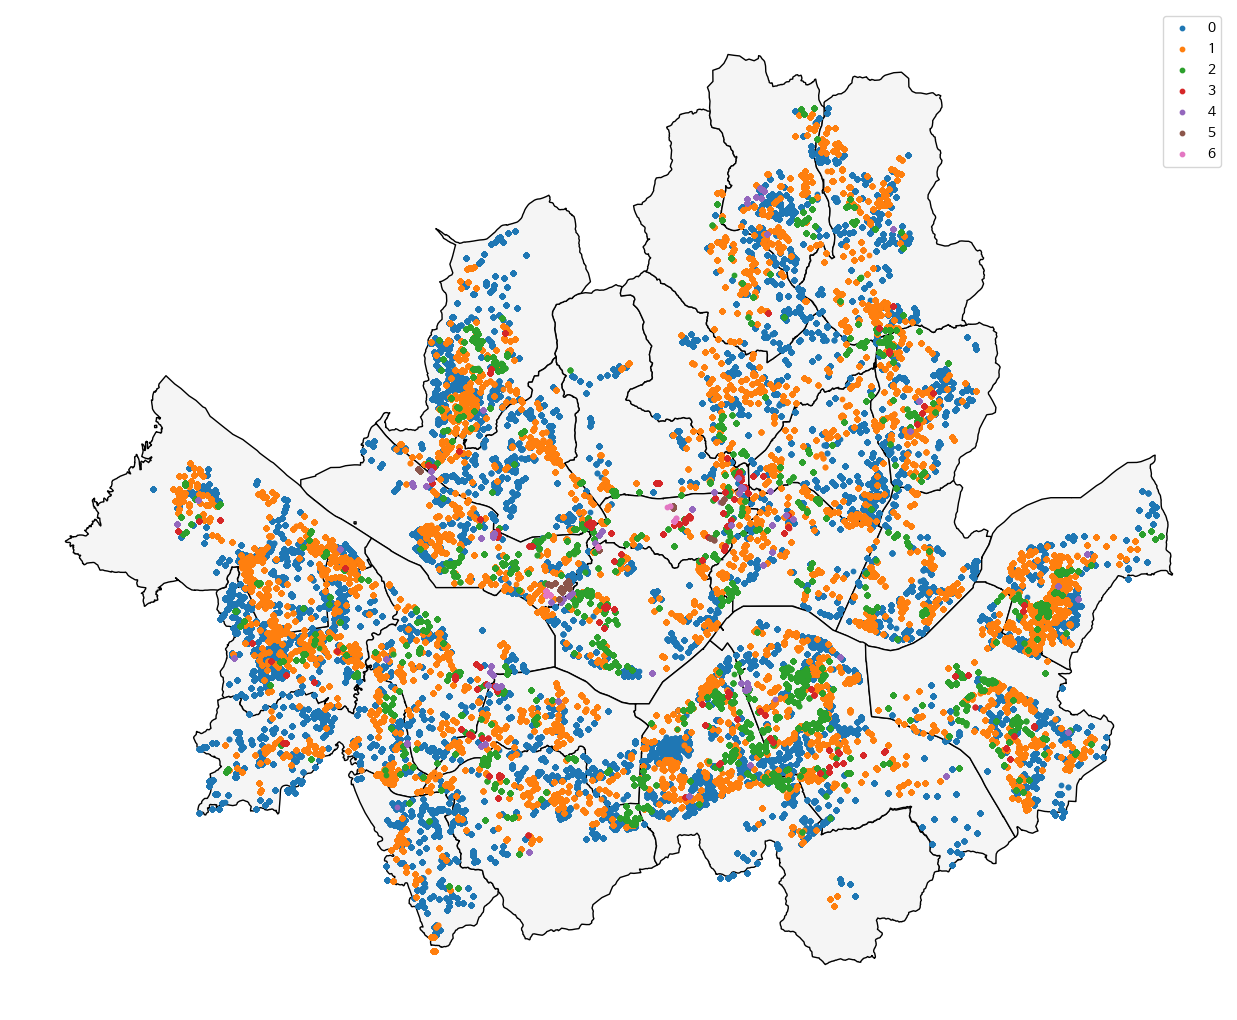

In [15]:
fig = plt.figure(figsize=(18, 13))
ax = fig.subplots(1, 1)
 
gdf_seoul.plot(color='whitesmoke', edgecolor='black', linewidth=1, ax=ax)

# '지하철역 수' 별로 아파트 위치에 다른 색상 적용
for num_stations, group in data_with_subway.groupby('지하철역 수'):
    ax.scatter(group['좌표X'], group['좌표Y'], label=f'{num_stations}', s=10)

# 지하철역 위치를 표시
# ax.scatter(seoul_stations['경도'], seoul_stations['위도'], color="red", marker='^', label='Subway Station', s=30)

# 레전드 추가
ax.legend()

ax.set_axis_off()

plt.show()

In [16]:
data_with_subway['log_target'] = np.log1p(data_with_subway['target'])

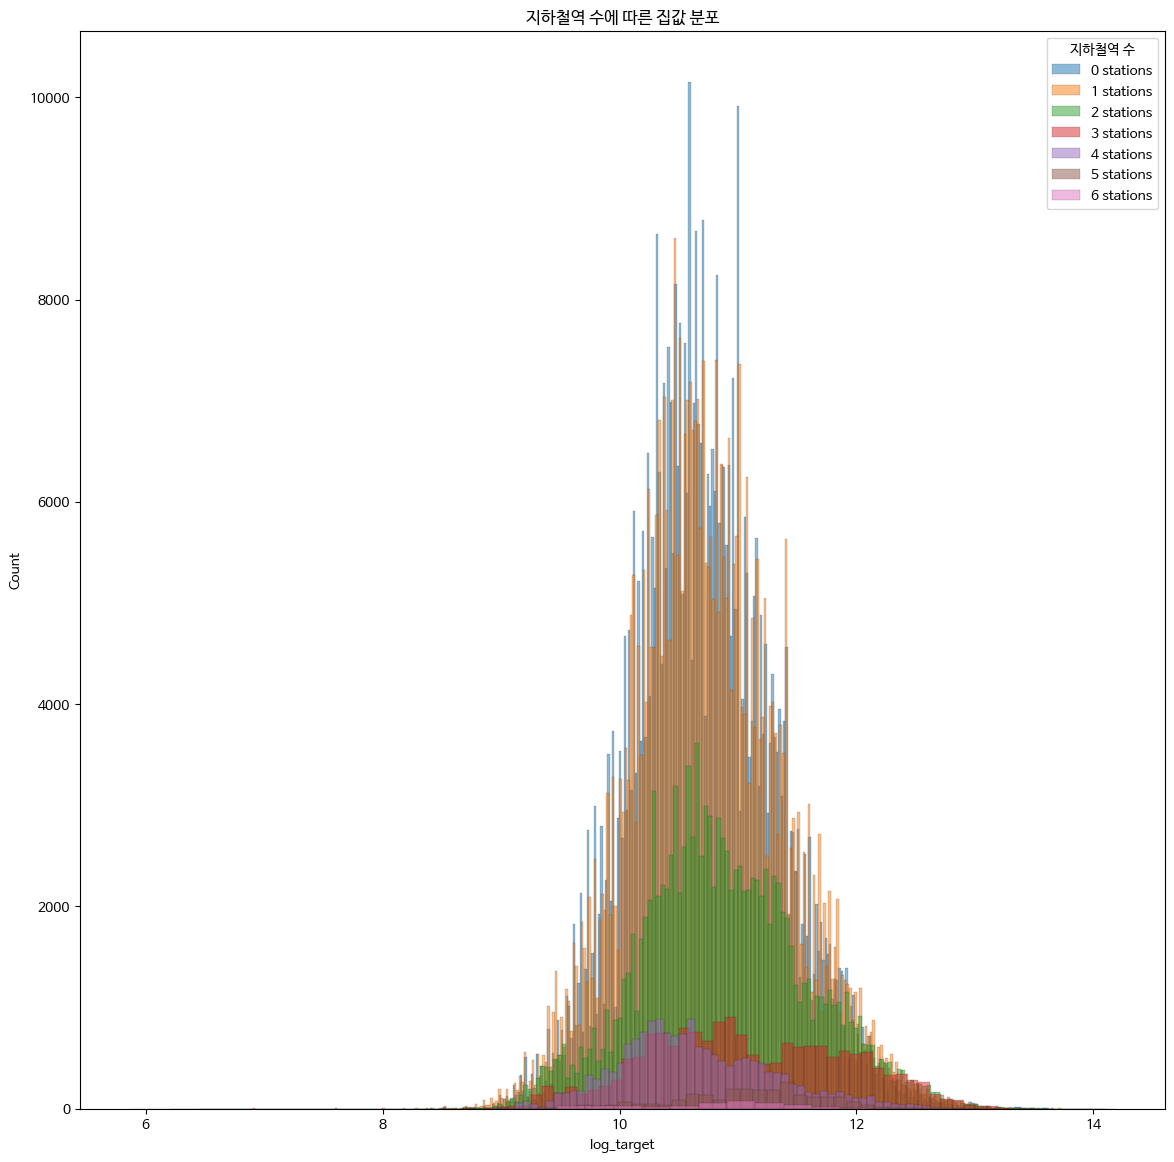

In [17]:
plt.figure(figsize=(14, 14))

# 지하철역의 수가 다른 데이터들을 각각 플롯
unique_station_counts = data_with_subway['지하철역 수'].unique()
for count in sorted(unique_station_counts):
    subset = data_with_subway[data_with_subway['지하철역 수'] == count]
    sns.histplot(data=subset, x='log_target', alpha=0.5, label=f'{count} stations', edgecolor='black', linewidth=0.1)

plt.title("지하철역 수에 따른 집값 분포")
plt.legend(title='지하철역 수')
plt.show()

In [18]:
data_with_subway['지하철역 수'].value_counts()

0    510803
1    450388
2    128769
3     17806
4     17523
5      2438
6       367
Name: 지하철역 수, dtype: int64

In [19]:
data_with_subway.sort_values(by='target', ascending=False)[:30]

,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,건축년도,...,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,is_test,지번주소,지하철역 수,log_target
1121926,서울특별시 강남구 청담동,129,129.0,0.0,PH129,273.9600,202204,28,16,2020,...,NaN,NaN,127.054292,37.526072,PH129,1450000.0,0,서울특별시 강남구 청담동 129,0,14.187075
1123440,서울특별시 용산구 한남동,410,410.0,0.0,파르크한남,268.6700,202204,30,5,2020,...,NaN,NaN,127.011443,37.531401,파르크한남,1350000.0,0,서울특별시 용산구 한남동 410,1,14.115616
936576,서울특별시 성동구 성수동1가,685-700,685.0,700.0,아크로서울포레스트,264.5460,202209,30,47,2020,...,Y,N,127.043853,37.544798,아크로서울포레스트,1300000.0,0,서울특별시 성동구 성수동1가 685-700,2,14.077876
1123439,서울특별시 용산구 한남동,410,410.0,0.0,파르크한남,268.9500,202112,13,2,2020,...,NaN,NaN,127.011443,37.531401,파르크한남,1200000.0,0,서울특별시 용산구 한남동 410,1,13.997833
1123438,서울특별시 용산구 한남동,410,410.0,0.0,파르크한남,268.6700,202111,26,4,2020,...,NaN,NaN,127.011443,37.531401,파르크한남,1170000.0,0,서울특별시 용산구 한남동 410,1,13.972515
1121927,서울특별시 강남구 청담동,129,129.0,0.0,PH129,273.9600,202103,4,14,2020,...,NaN,NaN,127.054292,37.526072,PH129,1150000.0,0,서울특별시 강남구 청담동 129,0,13.955273
1123437,서울특별시 용산구 한남동,410,410.0,0.0,파르크한남,268.9500,202111,24,3,2020,...,NaN,NaN,127.011443,37.531401,파르크한남,1150000.0,0,서울특별시 용산구 한남동 410,1,13.955273
857878,서울특별시 용산구 한남동,810,810.0,0.0,한남더힐,240.3050,202205,30,3,2011,...,Y,Y,127.009496,37.536978,한남더힐,1100000.0,0,서울특별시 용산구 한남동 810,0,13.910822
857870,서울특별시 용산구 한남동,810,810.0,0.0,한남더힐,240.3050,202303,10,5,2011,...,Y,Y,127.009496,37.536978,한남더힐,1100000.0,0,서울특별시 용산구 한남동 810,0,13.910822
1123442,서울특별시 용산구 한남동,410,410.0,0.0,파르크한남,268.6700,202109,9,2,2020,...,NaN,NaN,127.011443,37.531401,파르크한남,1080000.0,0,서울특별시 용산구 한남동 410,1,13.892473
